# Ajustement de données issues de la méthode Volt-Ampère-métrique

Les données sont issues de la discussion `https://moodle.u-paris.fr/mod/forum/discuss.php?d=81316` à la suite du TP du mercredi 12 octobre 2022.

In [26]:
# importations requises
import numpy as np
import matplotlib.pyplot as plt

# données
I = np.array([-11.48,-9.08,-6.82,-4.47,-2.24,0,2.21,4.43,6.66,8.89,11.13])   # en mA
U = np.array([-430,-349.4,-262.7,-172.3,-86.5,0,85.2,170.7,256.5,342.7,428]) # en mV

Calcul des incertitudes

In [27]:
u_I = ((1./100)*np.abs(I)+2*0.01)/(np.sqrt(3)) ; # en mA, calibre 40 mA
u_U = ((0.8/100)*np.abs(U)+1)/(np.sqrt(3)) ;     # en mV, calibre 4 V

Afin d'avoir des incertitudes macroscopiques, nous les multiplions arbitrairement par 25 ici pour mieux illustrer les choses.

In [28]:
u_U_ori = u_U # pour garder la valeur initiale correct
u_I_ori = u_I # idem

u_U = 25*u_U
u_I = 25*u_I

### Représentation avec `errorbar`

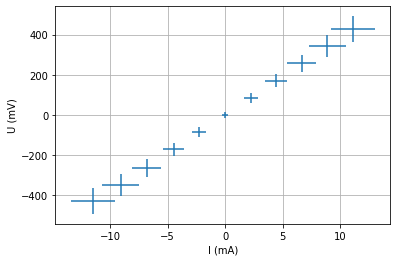

In [29]:
plt.errorbar(I, U, xerr=u_I, yerr=u_U, marker='', linestyle='')
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()

Attention, nous représentons ici les incertitudes `x10` pour plus de visibilité. Dans leur calcul on prendra soin de prendre la valeur absolue de $I$ et $U$ afin de ne pas avoir des incertitudes estimées négatives…

In [30]:
# fonction simple d'écriture de résultat
# par défaut, l'unité affichée sera des Ohm pour une variable notée R

def printResult(R,u_R,name='R',unit='Ω'):
    print('%s = %.2f ± %.2f %s'%(name,R,u_R,unit))
    
# Essai de la fonction
printResult(1,2)
printResult(-0.3,0.2,'a','m')

R = 1.00 ± 2.00 Ω
a = -0.30 ± 0.20 m


## Ajustement avec `SciPy`

R = 38.26 ± 0.14 Ω
offset = 1.06 ± 1.00 mV


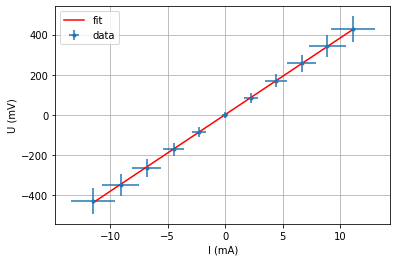

In [31]:
from scipy import stats

# regression
r  = stats.linregress(I,U)

# creation de la droite de régression
mn = np.min(I)
mx = np.max(I)
x1 = np.array([mn,mx])
y1 = r.slope*x1 + r.intercept

# création du graphique
plt.errorbar(I, U, xerr=u_I, yerr=u_U, fmt='.', label='data')
plt.plot(x1, y1, '-r', label='fit')
plt.legend()
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()

# impression des résultats d'ajustement
printResult(r.slope,r.stderr)
printResult(r.intercept,r.intercept_stderr,'offset','mV')

L'ajustement est affine ici, on ne peut imposer que l'ordonnée à l'origine passe bien par 0. Le modèle ajusté n'est pas celui du modèle physique (seconde loi d'Ohm), et ce degré de liberté supplémentaire change l'estimation de $R$ malheureusement.

Par ailleurs cet ajustement ne prend pas en compte les incertitudes. La valeur de $u_R$ est assurément très sous-estimée.

## Ajustement avec `polyfit`

In [32]:
# Fitting with polyfit 
p,V = np.polyfit(I, U, 1, cov=True)   # Fit with numpy.polyfit
print(p, V)

[38.25566661  1.05971484] [[0.01955887 0.00136912]
 [0.00136912 0.9913168 ]]


In [33]:
printResult(p[0],np.sqrt(V[0][0]))

R = 38.26 ± 0.14 Ω


Ajustement d'un polynôme de degré 1 (donc une loi toujours affine). Par ailleurs, l'estimation de l'incertitude est exact sous l'hypothèse d'indépendance de $R$ et de la pente, ce qui n'est pas exact.

Ici non plus, pas d'utilisation des incertitudes estimées sur les points de mesure.

## Ajustement avec `curvfit`
Ici nous pourrons imposer la fonction ajustée qui est une fonction linéaire, et non affine.

In [34]:
from scipy import optimize

# création de la fonction linéaire
def lin(x,a):
    return a*x

# ajustement
param,cov = optimize.curve_fit(lin, I, U, p0=[40], sigma=u_U)

# extraction de l'incertitude
err = np.zeros(np.size(param))
for i in range(np.size(param)):
    err[i] = np.sqrt(cov[i][i])

printResult(param[0],err[0])

R = 38.36 ± 0.12 Ω


Ici nous avons une estimation prenant en compte les incertitudes $u_U$, mais pas $u_I$, les plus grandes dans notre cas. L'estimation de $u_R$ est assurément trop petite.

## Estimation de l'incertitude par MC
L'outil précédent effectue le même type de calcul. Nous allons ici effectuer l'estimation de l'incertitude par MC sur la base de `curv_fit` car cet outil permet d'imposer une loi linéaire.

In [35]:
from scipy import optimize

def lin(x,a):
    return a*x

nbPseudoExp = 2048
pList = np.zeros(nbPseudoExp)
for i in range(nbPseudoExp):
    U_tmp = np.random.normal(U, u_U)
    I_tmp = np.random.normal(I, u_I)
    p,cov = optimize.curve_fit(lin, I_tmp, U_tmp, p0=[40])
    pList[i] = p[0]

In [36]:
printResult(np.mean(pList),np.std(pList))

R = 37.46 ± 3.62 Ω


Il nous prenons en compte non seulement l'incertitude $u_U$ mais aussi $u_I$. Et comme nous imposons un modèle linéaire conforme au modèle physique de référence, cet estimation est la plus correcte.

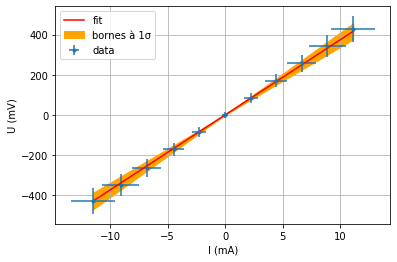

In [37]:
mn = np.min(I) # abscisse min
mx = np.max(I) # abscisse max
x1 = np.array([mn,mx]) 
sMean = np.mean(pList) # mean slope
ymean = sMean*x1
ylow  = (sMean-np.std(pList))*x1
yhigh = (sMean+np.std(pList))*x1

plt.errorbar(I, U, xerr=u_I, yerr=u_U, fmt='.', label='data')
plt.plot(x1, ymean, 'r', label="fit")
plt.fill_between(x1, ylow, y2=yhigh, color="orange", label="bornes à 1σ")
plt.legend()
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()

La zone orange pleine représente la zone à ±1σ pour la pente (donc $R$) calculé.

## Ajustement avec `linfitxy`
L'outil `linfitxy` effectue ces estimations par MC automatiquement, en utilisant les incertitudes tant en abscisse qu'en ordonnées. L'outil est utilisé à l'UFR de Physique et y a été développé. Il est installé sur la machine `jupy`. Sur une autre machine, il est nécessaire d'effectuer l'installation, et donc de disposer d'internet. Aussi, attention, il est à craindre que vous n'ayez pas accès à l'outil lors du concours. L'outil reste pratique, il est ici présenté pour référence.

Les lignes suivantes effectuent l'installation en cas de besoin.

In [38]:
import sys
import subprocess
import importlib
fitutils_info = importlib.util.find_spec("fitutils")
if fitutils_info == None:
  subprocess.check_call(['pip', 'install', 'fitutils'])

import fitutils as fu

R = 38.31 ± 2.91 Ω


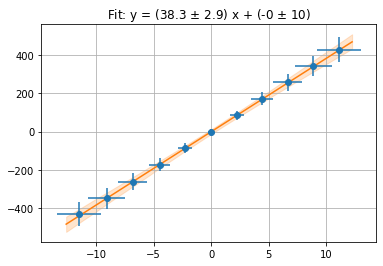

In [39]:
out=fu.linfitxy(I, U, u_I, u_U, plot=True)
plt.grid()

printResult(out[0],out[2])

Dans notre cas, l'ajustement est affine et ne correspond malheureusement pas au modèle physique. L'utilisation est cependant très simple et méritait d'être mentionnée.

## Exploitation des données sans ajustement

Pour exploiter les données sans ajustement, nous appliquons le modèle de la seconde loi d'Ohm pour chaque point. Pour cela il faut exclure la donnée où $I=0$.

In [40]:
UU = U[I!=0]
II = I[I!=0]
u_UU = u_U[I!=0]
u_II = u_I[I!=0]

RR   = UU/II
u_RR = RR*np.sqrt( (u_UU/UU)**2 + (u_II/II)**2 )

Text(0, 0.5, 'R (Ω)')

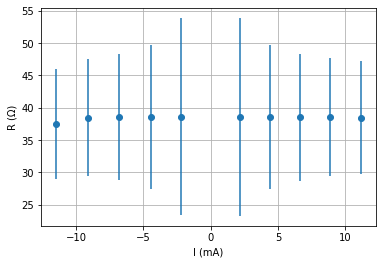

In [41]:
plt.errorbar(II, RR, yerr=u_RR, fmt='o')
plt.grid()
plt.xlabel('I (mA)')
plt.ylabel('R (Ω)')

L'estimation de l'incertitude passe aussi par un MC.

In [42]:
nbPseudoExp = 2048
rList = np.zeros(nbPseudoExp)

for i in range(nbPseudoExp):
    R_tmp = np.random.normal(RR, u_RR)
    rList[i] = np.mean(R_tmp)
  
printResult(np.mean(rList), np.std(rList))

R = 38.36 ± 3.52 Ω


On notera que l'incertitude est très similaire par l'utilisation de cette méthode à la sortie du MC de l'ajustement. Cette méthode, sans ajustement, est de fait bien plus simple à mettre en œuvre.

## Et si on reprenait les incertitudes réelles ? 

In [43]:
u_U = u_U_ori
u_I = u_I_ori

### Ajustement linéaire par MC

R = 38.26 ± 0.14 Ω


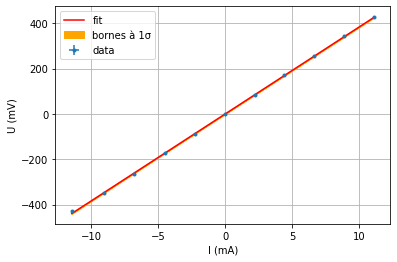

In [44]:
from scipy import optimize

def lin(x,a):
    return a*x

nbPseudoExp = 2048
pList = np.zeros(nbPseudoExp)
for i in range(nbPseudoExp):
    U_tmp = np.random.normal(U, u_U)
    I_tmp = np.random.normal(I, u_I)
    p,cov = optimize.curve_fit(lin, I_tmp, U_tmp, p0=[40])
    pList[i] = p[0]
    
printResult(np.mean(pList),np.std(pList))
    
mn = np.min(I) # abscisse min
mx = np.max(I) # abscisse max
x1 = np.array([mn,mx]) 
sMean = np.mean(pList) # mean slope
ymean = sMean*x1
ylow  = (sMean-np.std(pList))*x1
yhigh = (sMean+np.std(pList))*x1

plt.errorbar(I, U, xerr=u_I, yerr=u_U, fmt='.', label='data')
plt.plot(x1, ymean, 'r', label="fit")
plt.fill_between(x1, ylow, y2=yhigh, color="orange", label="bornes à 1σ")
plt.legend()
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()

Les incertitudes des points de données sont ici minuscules. A priori, à l'œil, pas de souci de compatibilité. Mais pour mieux voir les choses, il est préférable de passer aux résidus, i.e. la différences entre les points de mesure et l'ajustement.

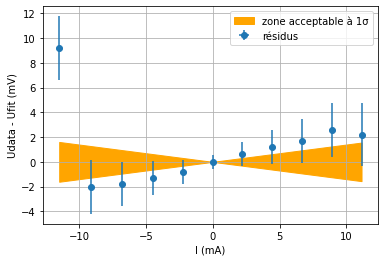

In [45]:
Ufit = sMean*I
plt.errorbar(I, U-Ufit, xerr=u_I, yerr=u_U, fmt='o', label='résidus')
x3  = np.array([mn,mx])
y3a = - np.std(pList)*x3
y3b = np.std(pList)*x3
plt.fill_between(x3,y3a,y2=y3b,color='orange',label='zone acceptable à 1σ')
plt.grid()
plt.xlabel('I (mA)')
plt.ylabel('Udata - Ufit (mV)')
plt.legend()

Avec cette représentation des résidus, il apparaît que le premier point est loin de la zone acceptable. On pourrait calculer sa compatibilité avec un z_test

In [46]:
z = abs(U[0]-Ufit[0])/np.sqrt( u_U[0]**2 + y3a[0]**2)
print(z)

3.041436098389003


Mais ce z_test est valable pour une donnée unique. Pas pour une donnée parmi $N$. En effet, lorsque $N$ est grand, la probabilité croit d'avoir un des points qui s'éloigne de cette valeur. Il ne faut alors pas faire un simple test à 5%. Des corrections existent. La plus simple, le test de Bonferroni consiste à faire un test à $0,05/N$. En pratique, cela consiste à comparer $z$ calculé précédemment à (on décortiquera le calcul…) : 

In [47]:
from scipy.stats import norm
norm.isf(0.025/10)

2.8070337683438042

Le $z$ trouvé pour ce premier point de mesure est supérieur à ce seuil. Le point n'est donc pas compatible avec l'attendu. Aussi, on peut raisonnablement s'interroger sur la prise de données. Dans ce cas, soit il est possible que la mesure soit entâchée d'une erreur auquel cas, on élimine le point ou on le reprend. Soit ce n'est pas le cas, on garde le point… et on médite soit sur le protocole, soit sur le modèle, soit sur l'opérateur/opératrice, soit… 

Si on élimine le point, on obtient…

R = 38.50 ± 0.16 Ω


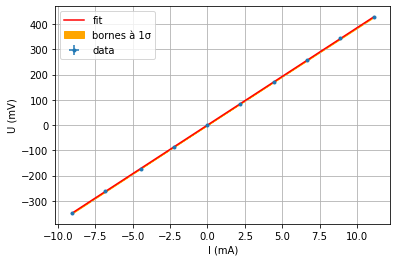

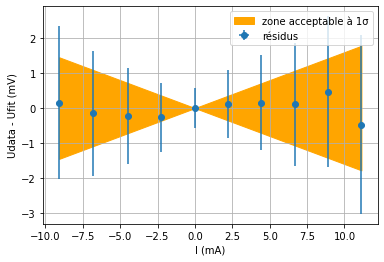

In [48]:
nbPseudoExp = 2048
pList = np.zeros(nbPseudoExp)
for i in range(nbPseudoExp):
    U_tmp = np.random.normal(U[1:], u_U[1:])
    I_tmp = np.random.normal(I[1:], u_I[1:])
    p,cov = optimize.curve_fit(lin, I_tmp, U_tmp, p0=[40])
    pList[i] = p[0]
    
printResult(np.mean(pList),np.std(pList))
    
mn = np.min(I[1:]) # abscisse min
mx = np.max(I[1:]) # abscisse max
x1 = np.array([mn,mx]) 
sMean = np.mean(pList) # mean slope
ymean = sMean*x1
ylow  = (sMean-np.std(pList))*x1
yhigh = (sMean+np.std(pList))*x1

plt.errorbar(I[1:], U[1:], xerr=u_I[1:], yerr=u_U[1:], fmt='.', label='data')
plt.plot(x1, ymean, 'r', label="fit")
plt.fill_between(x1, ylow, y2=yhigh, color="orange", label="bornes à 1σ")
plt.legend()
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()

plt.figure()
Ufit = sMean*I[1:]
plt.errorbar(I[1:], U[1:]-Ufit, xerr=u_I[1:], yerr=u_U[1:],fmt='o',label='résidus')
x3  = np.array([mn,mx])
y3a = - np.std(pList)*x3
y3b = np.std(pList)*x3
plt.fill_between(x3,y3a,y2=y3b,color='orange',label='zone acceptable à 1σ')
plt.grid()
plt.xlabel('I (mA)')
plt.ylabel('Udata - Ufit (mV)')
plt.legend()

Nous passons alors d'une mesure de $R=38,25±0,15\,Ω$ à $R=38,50±0,15\,Ω$, la différence étant assez significative au regard de l'incertitude de mesure annoncée.

### Exploitation sans ajustement

R = 38.42 ± 0.14 Ω


Text(0, 0.5, 'R (Ω)')

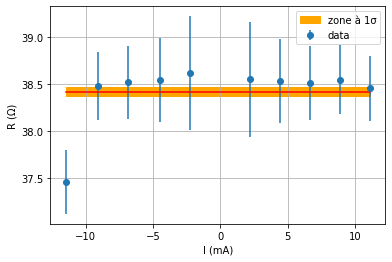

In [49]:
UU = U[I!=0]
II = I[I!=0]
u_UU = u_U[I!=0]
u_II = u_I[I!=0]

RR   = UU/II
u_RR = RR*np.sqrt( (u_UU/UU)**2 + (u_II/II)**2 )

plt.errorbar(II, RR, yerr=u_RR, fmt='o',label='data')

nbPseudoExp = 2048
rList = np.zeros(nbPseudoExp)

for i in range(nbPseudoExp):
    R_tmp = np.random.normal(RR, u_RR)
    rList[i] = np.mean(R_tmp)
  
printResult(np.mean(rList), np.std(rList))

x1 = np.array([np.min(II),np.max(II)])
ymoy  = np.ones(2)*np.mean(rList)
ylow  = ymoy - np.std(rList)/np.sqrt(RR.size)
yhigh = ymoy + np.std(rList)/np.sqrt(RR.size)
plt.plot(x1,ymoy,'r')
plt.fill_between(x1,ylow,y2=yhigh,color='orange',label='zone à 1σ')
plt.legend()
plt.grid()
plt.xlabel('I (mA)')
plt.ylabel('R (Ω)')

Comme plus haut, on note que le premier point semble pathologique. En l'excluant on obtient : 

R = 38.53 ± 0.15 Ω


Text(0, 0.5, 'R (Ω)')

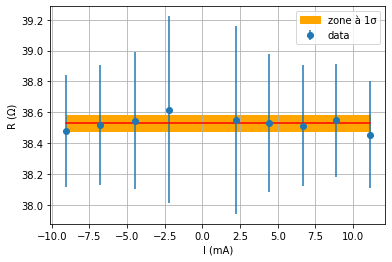

In [50]:
UU = U[I!=0][1:]
II = I[I!=0][1:]
u_UU = u_U[I!=0][1:]
u_II = u_I[I!=0][1:]

RR   = UU/II
u_RR = RR*np.sqrt( (u_UU/UU)**2 + (u_II/II)**2 )

plt.errorbar(II, RR, yerr=u_RR, fmt='o',label='data')

nbPseudoExp = 2048
rList = np.zeros(nbPseudoExp)

for i in range(nbPseudoExp):
    R_tmp = np.random.normal(RR, u_RR)
    rList[i] = np.mean(R_tmp)
  
printResult(np.mean(rList), np.std(rList))

x1 = np.array([np.min(II),np.max(II)])
ymoy  = np.ones(2)*np.mean(rList)
ylow  = ymoy - np.std(rList)/np.sqrt(RR.size)
yhigh = ymoy + np.std(rList)/np.sqrt(RR.size)
plt.plot(x1,ymoy,'r')
plt.fill_between(x1,ylow,y2=yhigh,color='orange',label='zone à 1σ')
plt.legend()
plt.grid()
plt.xlabel('I (mA)')
plt.ylabel('R (Ω)')

## Quelques remarques 
 - Pour les ajustements, dans ce cas particulier, il est important d'utiliser une fonction modèle cohérente donc linéaire et non affine 
 - Il n'est pas nécessaire d'effectuer un ajustement. Le calcul de $R$ pour chaque mesure marche tout aussi bien
 - Attention aux points aberrants. Si l'on ne trace pas les résidus, on ne les voit pas forcément